In [71]:
import benchmax.inspection as ev
import pandas as pd
import tikzplotlib
import matplotlib.pyplot as plt

stats    = ev.csv_to_pandas("stats_qe-qfnraqe_25-04-23_18:03_smtrat-coverings-EvalSettings.csv")
stats    = stats.join(ev.csv_to_pandas("stats_qe-qfnraqe_25-04-11_10:27_smtrat-nucad-EvalSettings.csv"))
stats    = stats.join(ev.csv_to_pandas("stats_qe-qfnraqe_25-04-23_18:03_smtrat-coverings-EvalPBcldboundsSettings.csv"))
stats    = stats.join(ev.csv_to_pandas("stats_qe-qfnraqe_25-04-17_11:09_smtrat-nucad-EvalPBcldboundsSettings.csv"))

stats = ev.rename_solvers(stats, {
 'smtrat-coverings-EvalSettings': "CAlC",
 'smtrat-nucad-EvalSettings': "NuCAD",
 'smtrat-coverings-EvalPBcldboundsSettings': "CAlC<BcLdBounds,BcLdBoundsCov>",
 'smtrat-nucad-EvalPBcldboundsSettings': "NuCAD<BcLdBounds>",
 })

def compute_poly_count(df, s):
    df[(s,'smtrat-cadcells_projections.poly_count')] = df[(s,'smtrat-cadcells_projections.coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.factor.level.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]
    df[(s,'smtrat-cadcells_projections.discres.poly_count')] = df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]

def compute_poly_total_degree(df, s):
    df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.sum')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.count')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.count')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.avg')] = df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] / df[(s,'smtrat-cadcells_projections.poly.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.max')] = df[[(s,'smtrat-cadcells_projections.coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.discriminant.total_degree.max'),(s,'smtrat-cadcells_projections.factor.total_degree.max'),(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.resultant.total_degree.max')]].max(axis=1)

def compute_interval_count(df, s):
    df[(s,'smtrat-cadcells_heuristics.interval.point_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.closed_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.open_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.open_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]

def compute_timer(df, s):
    def sum_timer(df,s,result,timers):
        df[(s,result+'.overall_ms')] = sum([df[(s,t+'.overall_ms')] for t in timers])
        df[(s,result+'.overall_µs')] = sum([df[(s,t+'.overall_µs')] for t in timers])
        df[(s,result+'.count')] = sum([df[(s,t+'.count')] for t in timers])
        df[(s,result+'.active_at_timeout')] = sum([df[(s,t+'.active_at_timeout')] for t in timers])

    sum_timer(df, s, 'smtrat-cadcells_projections.timer.real_root_isolation', ['smtrat-cadcells_projections.timer.real_roots','smtrat-cadcells_projections.timer.is_nullified', 'smtrat-cadcells_projections.timer.num_roots'])

    if 'smtrat-cadcells_projections.timer.evaluate.overall_ms' in ev.get_fields(df,s):
        sum_timer(df, s, 'smtrat-cadcells_projections.timer.evaluation', ['smtrat-cadcells_projections.timer.evaluate','smtrat-cadcells_projections.timer.is_zero'])

for s in ev.get_solvers(stats):
    compute_poly_count(stats, s)
    compute_poly_total_degree(stats, s)
    compute_interval_count(stats, s)
    compute_timer(stats, s)
    stats = stats.copy()

def sanitize(df):
    for solver in ev.get_solvers(df):
        df.loc[(df[(solver,'peak_memory_kbytes')]>3100000) & (df[(solver,'answer')]=='segfault'),(solver,'answer')] = 'memout'
        df.loc[(df[(solver,'answer')].isna()),(solver,'answer')] = 'timeout'

sanitize(stats)

ev.transform_to_seconds(stats)
ev.setup_accessible_styles()

solvers = list(ev.get_solvers(stats))

stats = stats.join(ev.csv_to_pandas('stats_analyzer-qfnra_25-01-16_14:33.csv'))
stats = stats.join(ev.csv_to_pandas('stats_analyzer-qfnra_25-03-17_11:02.csv'))

In [72]:
ev.inspect_answer(stats)


CAlC  NuCAD  CAlC<BcLdBounds,BcLdBoundsCov>  NuCAD<BcLdBounds>  \
count     12154  12154                           12154              12154   
sat        4352   4446                            4613               4517   
unsat      4908   4727                            4946               4736   
unknown       0      0                               0                  0   
timeout    2483   2544                            2184               2413   
memout      411    437                             411                488   
segfault      0      0                               0                  0   
solved     9260   9173                            9559               9253   

          smtrat-analyzer  analyzer.py  
count               12154        12154  
sat                     0            0  
unsat                   0            0  
unknown                 0        11840  
timeout                 3          194  
memout                  7            0  
segfault            12144          120  
solved                  0            0

Text(0, 0.5, 'running time (s)')

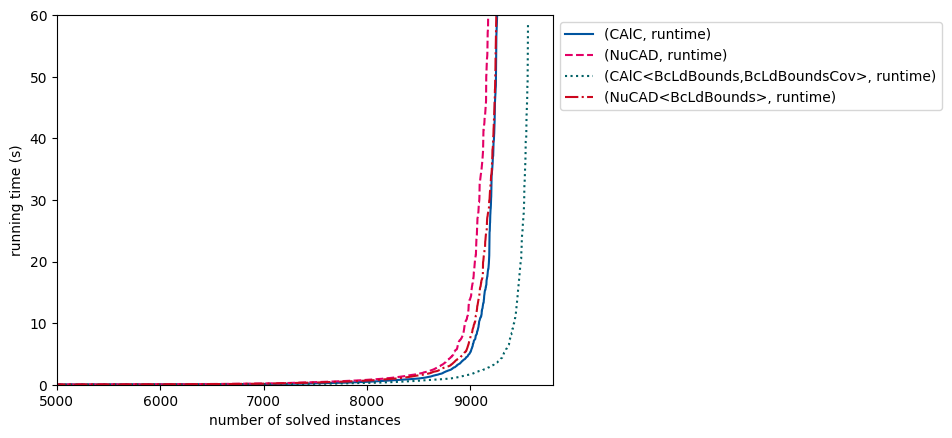

In [73]:
plot = ev.performance_profile(stats,solvers)
plot.axes.legend(bbox_to_anchor=(1,1))
plot.set_xlim(5000,9800)
plot.set_ylim(0,60)
plot.set_ylabel('running time (s)')

In [74]:
def solver_times(df,ss,features=['runtime','smtrat-cadcells_projections.timer.overall_s','smtrat-cadcells_projections.timer.resultant.overall_s','smtrat-cadcells_projections.timer.discriminant.overall_s','smtrat-cadcells_projections.timer.factors_nonconst.overall_s','smtrat-cadcells_projections.timer.derivative.overall_s','smtrat-cadcells_projections.timer.real_root_isolation.overall_s','smtrat-cadcells_projections.timer.evaluation.overall_s', 'non-proj-time']):
    df = ev.filter(stats,solved_by=ss)
    result = pd.DataFrame(index = features, columns = ss)
    for s in ss:
        for f in features:
            if f == 'non-proj-time':
                result.at[f,s] = "{:.2f}".format(df[(s,'runtime')].sum()-df[(s,'smtrat-cadcells_projections.timer.overall_s')].sum()) + " (" + "{:.2f}".format((df[(s,'runtime')].sum()-df[(s,'smtrat-cadcells_projections.timer.overall_s')].sum())/df[(s,'runtime')].sum()*100) + "%)"
                continue
            result.at[f,s] = "{:.2f}".format(df[(s,f)].sum()) + " (" + "{:.2f}".format(df[(s,f)].sum()/df[(s,'runtime')].sum()*100) + "%)"

    return result

## NuCAD vs CAlC

### Best Variants

In [75]:
ev.inspect_answer(ev.filter_solvers(stats,['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']))

CAlC<BcLdBounds,BcLdBoundsCov>  NuCAD<BcLdBounds>
count                             12154              12154
sat                                4613               4517
unsat                              4946               4736
timeout                            2184               2413
memout                              411                488
solved                             9559               9253

In [76]:
ev.unique_solved_instances(stats,['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])

num. unique instances  \
()                                                                   2479   
(CAlC<BcLdBounds,BcLdBoundsCov>,)                                     422   
(NuCAD<BcLdBounds>,)                                                  116   
(CAlC<BcLdBounds,BcLdBoundsCov>, NuCAD<BcLdBoun...                   9137   

                                                    rel. unique instances  
()                                                               0.203966  
(CAlC<BcLdBounds,BcLdBoundsCov>,)                                0.034721  
(NuCAD<BcLdBounds>,)                                             0.009544  
(CAlC<BcLdBounds,BcLdBoundsCov>, NuCAD<BcLdBoun...               0.751769

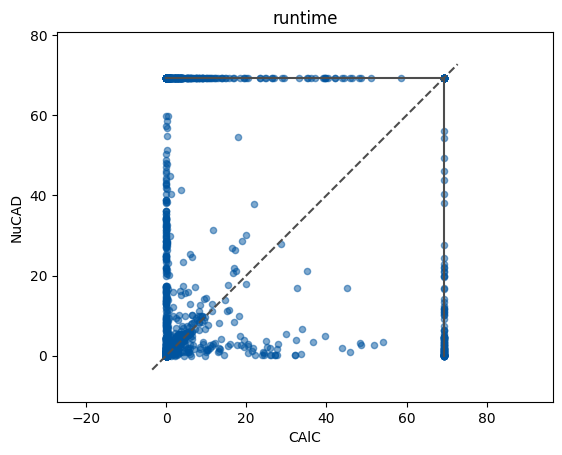

In [77]:
ax = ev.scatter(stats, "CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>", 'runtime')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)
ax.set_ylabel('NuCAD')
ax.set_xlabel('CAlC')
tikzplotlib.save('results_qeqfnra_nucad_calc.tex',axis_width='7cm',axis_height='7cm')

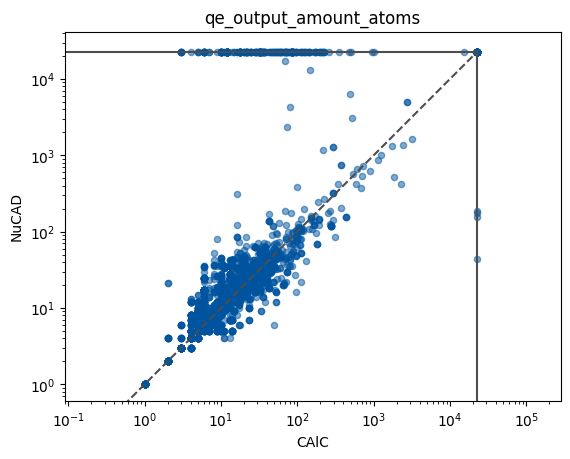

In [78]:
ax = ev.scatter(stats, "CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>", 'qe_output_amount_atoms')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('NuCAD')
ax.set_xlabel('CAlC')
tikzplotlib.save('output_qeqfnra_nucad_calc.tex',axis_width='7cm',axis_height='7cm')

In [79]:
for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, ev.filter(stats,solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])[(s,'qe_output_amount_atoms')].sum())

CAlC<BcLdBounds,BcLdBoundsCov> 93118.0
NuCAD<BcLdBounds> 142668.0


In [80]:
for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, ev.filter(stats,solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])[(s,'qe_tree_num_leaves')].sum())

CAlC<BcLdBounds,BcLdBoundsCov> 123696.0
NuCAD<BcLdBounds> 166819.0


In [81]:
for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, ev.filter(stats,solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])[(s,'qe_tree_num_nodes')].sum())

CAlC<BcLdBounds,BcLdBoundsCov> 173378.0
NuCAD<BcLdBounds> 727891.0


In [82]:
for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, ev.filter(stats,solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])[(s,'smtrat-cadcells_heuristics.section.count')].sum())

CAlC<BcLdBounds,BcLdBoundsCov> 100492.0
NuCAD<BcLdBounds> 3003788.0


In [83]:
stats1 = ev.filter(stats, solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])

for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, (stats1[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')].sum()))
    print(s, (stats1[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')].sum()) / (stats1[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.open_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')].sum()))


CAlC<BcLdBounds,BcLdBoundsCov> 100492.0
CAlC<BcLdBounds,BcLdBoundsCov> 0.14210846355087323
NuCAD<BcLdBounds> 3003788.0
NuCAD<BcLdBounds> 0.8089878320073687


In [84]:
stats1 = ev.filter(stats, solved_by=['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])

for s in ['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>']:
    print(s, (stats1[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')].sum()) / (stats1[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')].sum() + stats1[(s,'smtrat-cadcells_heuristics.interval.open_count.by_depth.total')].sum()))

CAlC<BcLdBounds,BcLdBoundsCov> 0.9019167306785701
NuCAD<BcLdBounds> 0.05309969093329122


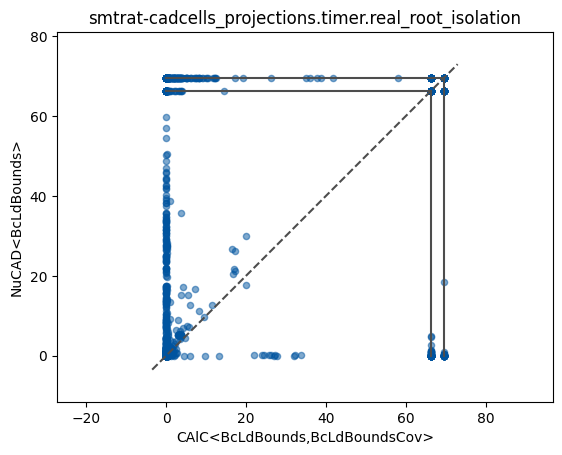

In [85]:
ax = ev.scatter(stats, "CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>", 'smtrat-cadcells_projections.timer.real_root_isolation')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

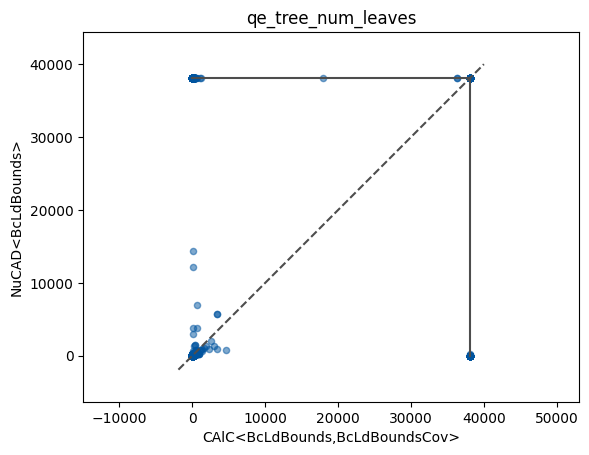

In [86]:
ax = ev.scatter(stats, "CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>", 'qe_tree_num_leaves')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

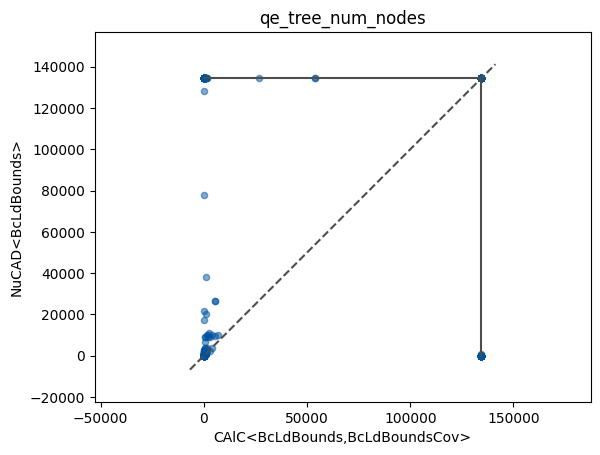

In [87]:
ax = ev.scatter(stats, "CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>", 'qe_tree_num_nodes')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

In [88]:
tbl = solver_times(stats,['CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])
tbl

CAlC<BcLdBounds,BcLdBoundsCov>  \
runtime                                                         4007.16 (100.00%)   
smtrat-cadcells_projections.timer.overall_s                       865.92 (21.61%)   
smtrat-cadcells_projections.timer.resultant.ove...                   0.24 (0.01%)   
smtrat-cadcells_projections.timer.discriminant....                  15.09 (0.38%)   
smtrat-cadcells_projections.timer.factors_nonco...                  18.96 (0.47%)   
smtrat-cadcells_projections.timer.derivative.ov...                   0.00 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...                704.91 (17.59%)   
smtrat-cadcells_projections.timer.evaluation.ov...                 111.79 (2.79%)   
non-proj-time                                                    3141.23 (78.39%)   

                                                    NuCAD<BcLdBounds>  
runtime                                             7682.14 (100.00%)  
smtrat-cadcells_projections.timer.overall_s          4944.00 (64.36%)  
smtrat-cadcells_projections.timer.resultant.ove...       3.73 (0.05%)  
smtrat-cadcells_projections.timer.discriminant....      18.58 (0.24%)  
smtrat-cadcells_projections.timer.factors_nonco...      59.04 (0.77%)  
smtrat-cadcells_projections.timer.derivative.ov...       0.02 (0.00%)  
smtrat-cadcells_projections.timer.real_root_iso...   4652.47 (60.56%)  
smtrat-cadcells_projections.timer.evaluation.ov...     187.80 (2.44%)  
non-proj-time                                        2738.14 (35.64%)

In [89]:
print(tbl.to_latex())

\begin{tabular}{lll}
\toprule
 & CAlC<BcLdBounds,BcLdBoundsCov> & NuCAD<BcLdBounds> \\
\midrule
runtime & 4007.16 (100.00%) & 7682.14 (100.00%) \\
smtrat-cadcells_projections.timer.overall_s & 865.92 (21.61%) & 4944.00 (64.36%) \\
smtrat-cadcells_projections.timer.resultant.overall_s & 0.24 (0.01%) & 3.73 (0.05%) \\
smtrat-cadcells_projections.timer.discriminant.overall_s & 15.09 (0.38%) & 18.58 (0.24%) \\
smtrat-cadcells_projections.timer.factors_nonconst.overall_s & 18.96 (0.47%) & 59.04 (0.77%) \\
smtrat-cadcells_projections.timer.derivative.overall_s & 0.00 (0.00%) & 0.02 (0.00%) \\
smtrat-cadcells_projections.timer.real_root_isolation.overall_s & 704.91 (17.59%) & 4652.47 (60.56%) \\
smtrat-cadcells_projections.timer.evaluation.overall_s & 111.79 (2.79%) & 187.80 (2.44%) \\
non-proj-time & 3141.23 (78.39%) & 2738.14 (35.64%) \\
\bottomrule
\end{tabular}



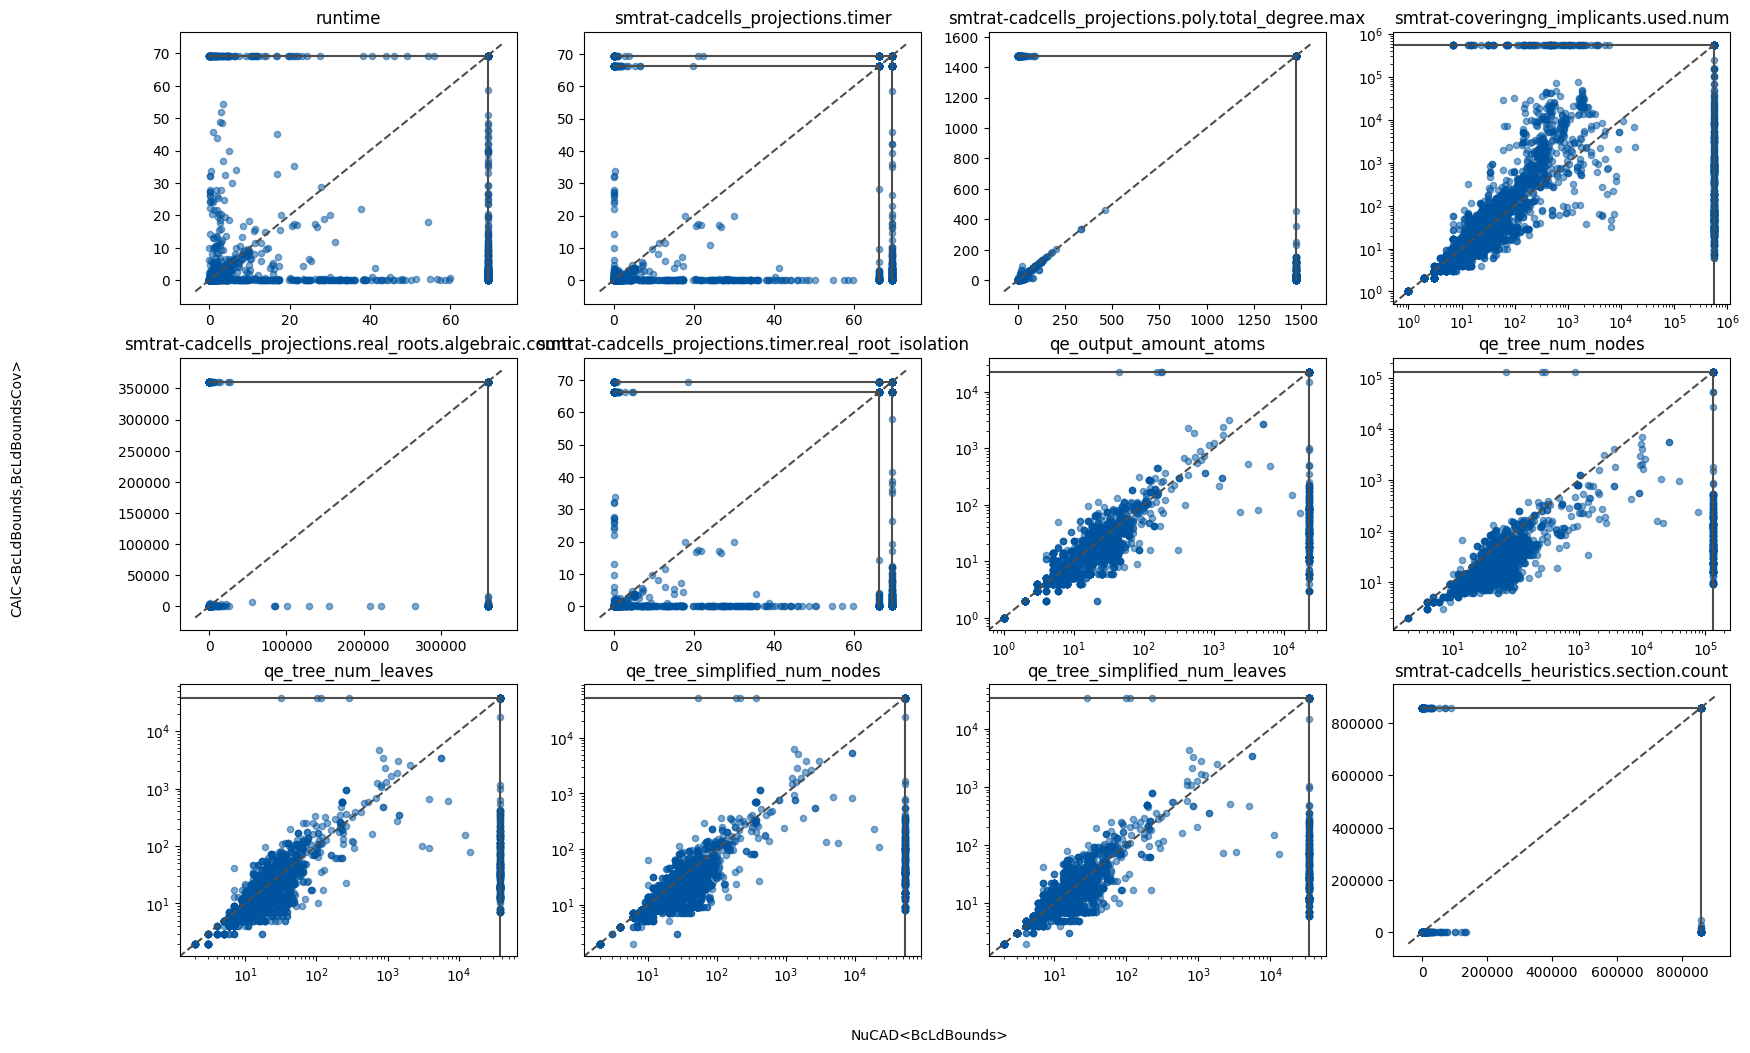

In [90]:
axs=ev.scatter_multi(stats,"NuCAD<BcLdBounds>","CAlC<BcLdBounds,BcLdBoundsCov>",['runtime','smtrat-cadcells_projections.timer','smtrat-cadcells_projections.poly.total_degree.max','smtrat-coveringng_implicants.used.num','smtrat-cadcells_projections.real_roots.algebraic.count','smtrat-cadcells_projections.timer.real_root_isolation','qe_output_amount_atoms','qe_tree_num_nodes','qe_tree_num_leaves','qe_tree_simplified_num_nodes','qe_tree_simplified_num_leaves','smtrat-cadcells_heuristics.section.count'])

for idx in [3,6,7,8,9,10]:
    axs.reshape(-1)[idx].set_xscale('log')
    axs.reshape(-1)[idx].set_yscale('log')


### Base Variants

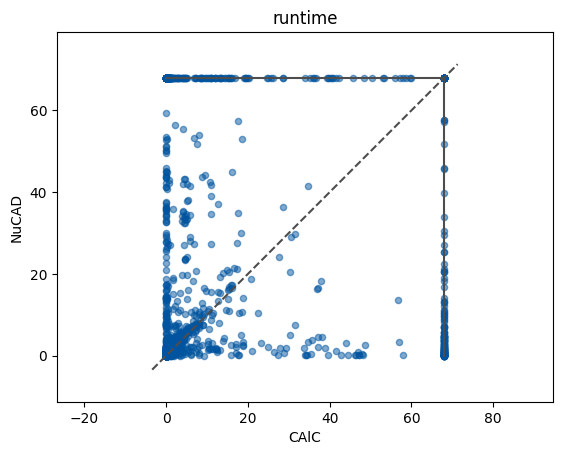

In [91]:
ax = ev.scatter(stats, "CAlC", "NuCAD", 'runtime')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)
#tikzplotlib.save('results_qeqfnra_nucad_calc.tex',axis_width='7cm',axis_height='7cm')

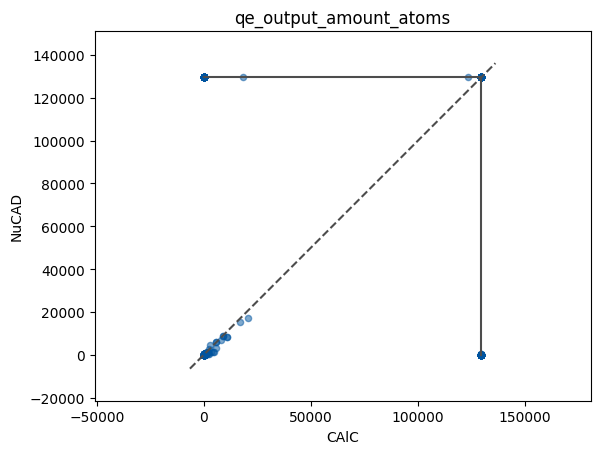

In [92]:
ax = ev.scatter(stats, "CAlC", "NuCAD", 'qe_output_amount_atoms')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

In [93]:
ev.unique_solved_instances(stats,['NuCAD','CAlC'])

num. unique instances  rel. unique instances
()                              2749               0.226181
(NuCAD,)                         145               0.011930
(CAlC,)                          232               0.019088
(NuCAD, CAlC)                   9028               0.742801

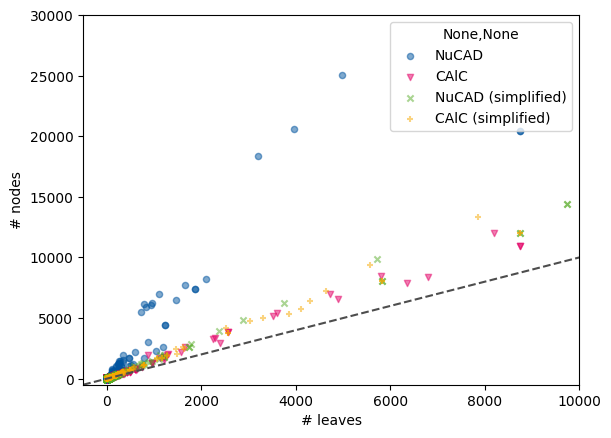

In [94]:
ax = plt.gca()
stats1 = ev.filter(stats, solved_by=["NuCAD","CAlC"])
stats1.plot.scatter(ax = ax, x=("NuCAD", "qe_tree_num_leaves"), y=("NuCAD", "qe_tree_num_nodes"), label="NuCAD", c='#00549F', marker='o', alpha=0.5)
stats1.plot.scatter(ax = ax, x=("CAlC", "qe_tree_num_leaves"), y=("CAlC", "qe_tree_num_nodes"), label="CAlC", c='#E30066', marker='v', alpha=0.5)
stats1.plot.scatter(ax = ax, x=("NuCAD", "qe_tree_simplified_num_leaves"), y=("NuCAD", "qe_tree_simplified_num_nodes"), label="NuCAD (simplified)", c='#57AB27', marker='x', alpha=0.5)
stats1.plot.scatter(ax = ax, x=("CAlC", "qe_tree_simplified_num_leaves"), y=("CAlC", "qe_tree_simplified_num_nodes"), label="CAlC (simplified)", c='#F6A800', marker='+', alpha=0.5)
#ev.scatter_axis_equal(ax)
ax.set_xlabel("# leaves")
ax.set_ylabel("# nodes")
ax.set_xlim(-500,10000)
ax.set_ylim(-500,30000)
ev.scatter_equal_line(ax)
#tikzplotlib.save('scatter_tree_both_nucad_calc.tex',axis_width='7cm',axis_height='7cm')

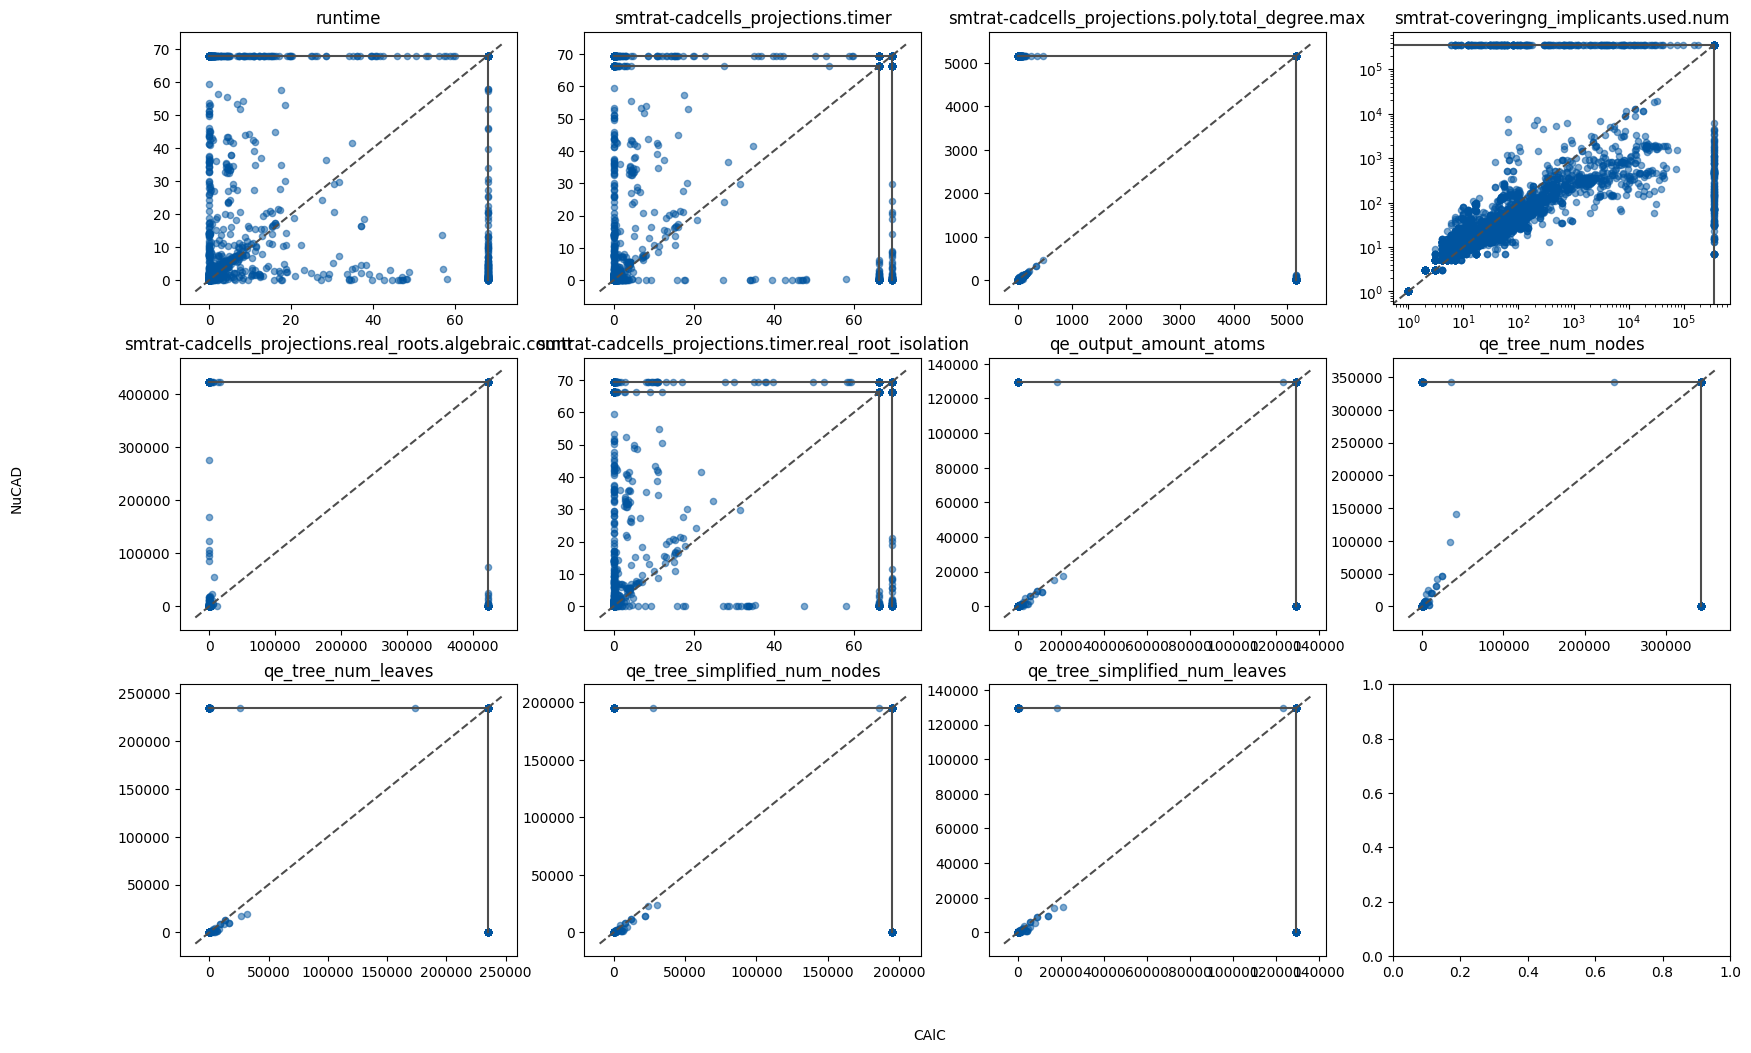

In [95]:
axs=ev.scatter_multi(stats,'CAlC','NuCAD',['runtime','smtrat-cadcells_projections.timer','smtrat-cadcells_projections.poly.total_degree.max','smtrat-coveringng_implicants.used.num','smtrat-cadcells_projections.real_roots.algebraic.count','smtrat-cadcells_projections.timer.real_root_isolation','qe_output_amount_atoms','qe_tree_num_nodes','qe_tree_num_leaves','qe_tree_simplified_num_nodes','qe_tree_simplified_num_leaves'])

axs.reshape(-1)[3].set_xscale('log')
axs.reshape(-1)[3].set_yscale('log')

In [96]:
tbl = ev.compare_attributes(stats, 'CAlC','NuCAD', [('analyzer.py', 'formula_dag_num_nodes'),('analyzer.py', 'formula_arith_max_degree')])
tbl


instances (analyzer.py, formula_dag_num_nodes)               \
              solved                                 mean  median  min   
both            9028                           430.077204    65.0  0.0   
only CAlC        232                           833.116379   306.5  0.0   
only NuCAD       145                          1565.124138  2094.0  0.0   
none            2749                         13591.372863  1427.0  0.0   

                     (analyzer.py, formula_arith_max_degree)                    
                 max                                    mean median  min   max  
both          6417.0                                5.134360    3.0  0.0  44.0  
only CAlC     4768.0                                9.849138    3.0  0.0  94.0  
only NuCAD    3703.0                                3.800000    2.0  0.0  16.0  
none        664211.0                                2.637686    2.0  0.0  22.0

In [97]:
print(tbl.to_latex(float_format=lambda x: '%.0f' % x if x == int(x) else '%.2f' % x))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & instances & \multicolumn{4}{r}{('analyzer.py', 'formula_dag_num_nodes')} & \multicolumn{4}{r}{('analyzer.py', 'formula_arith_max_degree')} \\
 & solved & mean & median & min & max & mean & median & min & max \\
\midrule
both & 9028 & 430.08 & 65 & 0 & 6417 & 5.13 & 3 & 0 & 44 \\
only CAlC & 232 & 833.12 & 306.50 & 0 & 4768 & 9.85 & 3 & 0 & 94 \\
only NuCAD & 145 & 1565.12 & 2094 & 0 & 3703 & 3.80 & 2 & 0 & 16 \\
none & 2749 & 13591.37 & 1427 & 0 & 664211 & 2.64 & 2 & 0 & 22 \\
\bottomrule
\end{tabular}



In [98]:
for s in ['NuCAD','CAlC']:
    #print(s, ev.filter(stats,solved_by=['NuCAD','CAlC'])[(s,'qe_tree_num_nodes')].sum())
    #print(s, ev.filter(stats,solved_by=['NuCAD','CAlC'])[(s,'qe_tree_simplified_num_nodes')].sum())
    print(s, ev.filter(stats,solved_by=['NuCAD','CAlC'])[(s,'qe_tree_num_leaves')].sum())
    #print(s, ev.filter(stats,solved_by=['NuCAD','CAlC'])[(s,'qe_tree_simplified_num_leaves')].sum())

NuCAD 261391.0
CAlC 376670.0


## Base vs Best Variant

In [99]:
ev.inspect_answer(ev.filter_solvers(stats,['CAlC','CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD','NuCAD<BcLdBounds>']))[['CAlC','CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD','NuCAD<BcLdBounds>']]

CAlC  CAlC<BcLdBounds,BcLdBoundsCov>  NuCAD  NuCAD<BcLdBounds>
count    12154                           12154  12154              12154
sat       4352                            4613   4446               4517
unsat     4908                            4946   4727               4736
timeout   2483                            2184   2544               2413
memout     411                             411    437                488
solved    9260                            9559   9173               9253

In [100]:
for s in ['CAlC','CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD','NuCAD<BcLdBounds>']:
    print(s, ev.filter(stats,solved_by=['CAlC','NuCAD','CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])[(s,'qe_output_amount_atoms')].sum())

CAlC 229019.0
CAlC<BcLdBounds,BcLdBoundsCov> 89792.0
NuCAD 181061.0
NuCAD<BcLdBounds> 139944.0


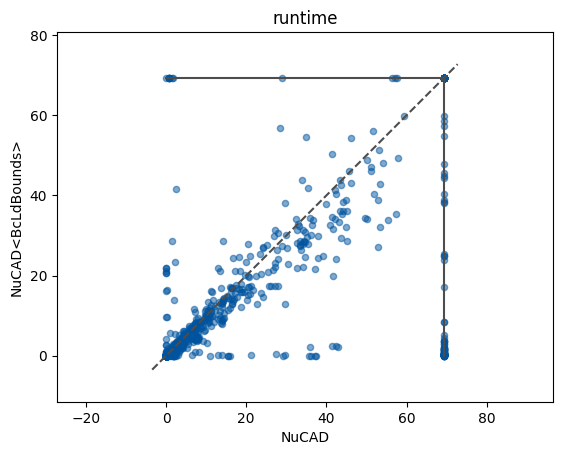

In [101]:
ax = ev.scatter(stats, "NuCAD","NuCAD<BcLdBounds>", 'runtime')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

In [102]:
ax = ev.scatter(stats, "NuCAD","NuCAD<BcLdBounds>", 'smtrat-cadcells_projections.timer.real_root_isolation')
ev.scatter_equal_line(ax)
ev.scatter_axis_equal(ax)

In [103]:
def solver_times(df,ss,features=['runtime','smtrat-cadcells_projections.timer.overall_s','smtrat-cadcells_projections.timer.resultant.overall_s','smtrat-cadcells_projections.timer.discriminant.overall_s','smtrat-cadcells_projections.timer.factors_nonconst.overall_s','smtrat-cadcells_projections.timer.derivative.overall_s','smtrat-cadcells_projections.timer.real_root_isolation.overall_s','smtrat-cadcells_projections.timer.evaluation.overall_s', 'non-proj-time']):
    df = ev.filter(stats,solved_by=ss)
    result = pd.DataFrame(index = features, columns = ss)
    for s in ss:
        for f in features:
            if f == 'non-proj-time':
                result.at[f,s] = "{:.2f}".format(df[(s,'runtime')].sum()-df[(s,'smtrat-cadcells_projections.timer.overall_s')].sum()) + " (" + "{:.2f}".format((df[(s,'runtime')].sum()-df[(s,'smtrat-cadcells_projections.timer.overall_s')].sum())/df[(s,'runtime')].sum()*100) + "%)"
                continue
            result.at[f,s] = "{:.2f}".format(df[(s,f)].sum()) + " (" + "{:.2f}".format(df[(s,f)].sum()/df[(s,'runtime')].sum()*100) + "%)"

    return result

solver_times(stats,['CAlC','NuCAD','CAlC<BcLdBounds,BcLdBoundsCov>','NuCAD<BcLdBounds>'])

CAlC  \
runtime                                             5020.99 (100.00%)   
smtrat-cadcells_projections.timer.overall_s          1907.16 (37.98%)   
smtrat-cadcells_projections.timer.resultant.ove...       0.19 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....      14.87 (0.30%)   
smtrat-cadcells_projections.timer.factors_nonco...      18.15 (0.36%)   
smtrat-cadcells_projections.timer.derivative.ov...       0.01 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...   1513.27 (30.14%)   
smtrat-cadcells_projections.timer.evaluation.ov...     344.44 (6.86%)   
non-proj-time                                        3113.82 (62.02%)   

                                                                NuCAD  \
runtime                                             7928.67 (100.00%)   
smtrat-cadcells_projections.timer.overall_s          5301.75 (66.87%)   
smtrat-cadcells_projections.timer.resultant.ove...       0.26 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....      15.57 (0.20%)   
smtrat-cadcells_projections.timer.factors_nonco...      23.48 (0.30%)   
smtrat-cadcells_projections.timer.derivative.ov...       0.02 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...   4995.76 (63.01%)   
smtrat-cadcells_projections.timer.evaluation.ov...     244.44 (3.08%)   
non-proj-time                                        2626.92 (33.13%)   

                                                   CAlC<BcLdBounds,BcLdBoundsCov>  \
runtime                                                         3813.82 (100.00%)   
smtrat-cadcells_projections.timer.overall_s                       815.94 (21.39%)   
smtrat-cadcells_projections.timer.resultant.ove...                   0.18 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....                  14.71 (0.39%)   
smtrat-cadcells_projections.timer.factors_nonco...                  18.16 (0.48%)   
smtrat-cadcells_projections.timer.derivative.ov...                   0.00 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...                663.13 (17.39%)   
smtrat-cadcells_projections.timer.evaluation.ov...                 105.39 (2.76%)   
non-proj-time                                                    2997.88 (78.61%)   

                                                    NuCAD<BcLdBounds>  
runtime                                             6791.02 (100.00%)  
smtrat-cadcells_projections.timer.overall_s          4199.65 (61.84%)  
smtrat-cadcells_projections.timer.resultant.ove...       0.26 (0.00%)  
smtrat-cadcells_projections.timer.discriminant....      16.17 (0.24%)  
smtrat-cadcells_projections.timer.factors_nonco...      24.58 (0.36%)  
smtrat-cadcells_projections.timer.derivative.ov...       0.02 (0.00%)  
smtrat-cadcells_projections.timer.real_root_iso...   3972.44 (58.50%)  
smtrat-cadcells_projections.timer.evaluation.ov...     165.08 (2.43%)  
non-proj-time                                        2591.36 (38.16%)

In [104]:
solver_times(stats,['CAlC','NuCAD',"CAlC<BcLdBounds,BcLdBoundsCov>","NuCAD<BcLdBounds>"])

CAlC  \
runtime                                             5020.99 (100.00%)   
smtrat-cadcells_projections.timer.overall_s          1907.16 (37.98%)   
smtrat-cadcells_projections.timer.resultant.ove...       0.19 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....      14.87 (0.30%)   
smtrat-cadcells_projections.timer.factors_nonco...      18.15 (0.36%)   
smtrat-cadcells_projections.timer.derivative.ov...       0.01 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...   1513.27 (30.14%)   
smtrat-cadcells_projections.timer.evaluation.ov...     344.44 (6.86%)   
non-proj-time                                        3113.82 (62.02%)   

                                                                NuCAD  \
runtime                                             7928.67 (100.00%)   
smtrat-cadcells_projections.timer.overall_s          5301.75 (66.87%)   
smtrat-cadcells_projections.timer.resultant.ove...       0.26 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....      15.57 (0.20%)   
smtrat-cadcells_projections.timer.factors_nonco...      23.48 (0.30%)   
smtrat-cadcells_projections.timer.derivative.ov...       0.02 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...   4995.76 (63.01%)   
smtrat-cadcells_projections.timer.evaluation.ov...     244.44 (3.08%)   
non-proj-time                                        2626.92 (33.13%)   

                                                   CAlC<BcLdBounds,BcLdBoundsCov>  \
runtime                                                         3813.82 (100.00%)   
smtrat-cadcells_projections.timer.overall_s                       815.94 (21.39%)   
smtrat-cadcells_projections.timer.resultant.ove...                   0.18 (0.00%)   
smtrat-cadcells_projections.timer.discriminant....                  14.71 (0.39%)   
smtrat-cadcells_projections.timer.factors_nonco...                  18.16 (0.48%)   
smtrat-cadcells_projections.timer.derivative.ov...                   0.00 (0.00%)   
smtrat-cadcells_projections.timer.real_root_iso...                663.13 (17.39%)   
smtrat-cadcells_projections.timer.evaluation.ov...                 105.39 (2.76%)   
non-proj-time                                                    2997.88 (78.61%)   

                                                    NuCAD<BcLdBounds>  
runtime                                             6791.02 (100.00%)  
smtrat-cadcells_projections.timer.overall_s          4199.65 (61.84%)  
smtrat-cadcells_projections.timer.resultant.ove...       0.26 (0.00%)  
smtrat-cadcells_projections.timer.discriminant....      16.17 (0.24%)  
smtrat-cadcells_projections.timer.factors_nonco...      24.58 (0.36%)  
smtrat-cadcells_projections.timer.derivative.ov...       0.02 (0.00%)  
smtrat-cadcells_projections.timer.real_root_iso...   3972.44 (58.50%)  
smtrat-cadcells_projections.timer.evaluation.ov...     165.08 (2.43%)  
non-proj-time                                        2591.36 (38.16%)